In [1]:
from colorcloud.chen2020mvlidarnet import MVLidarNet, SemanticSegmentationTask
from colorcloud.UFGsim2024infufg import ProjectionToTensorTransformSim, UFGSimDataset, SphericalProjection
from colorcloud.behley2019iccv import SphericalProjection, SemanticSegmentationLDM, ProjectionTransform, SemanticKITTIDataset
from torch.nn import CrossEntropyLoss
import lightning as L
import wandb
from lightning.pytorch.loggers import WandbLogger
from datetime import datetime
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import AdamW
from torchmetrics.classification import Accuracy
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import Dice
from torchmetrics.classification import MulticlassF1Score

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Lightning training

In [3]:
# data = SemanticSegmentationLDM(eval_batch_size=4, train_batch_size=4)
# data.setup('fit')
# epoch_steps = len(data.train_dataloader())

In [4]:
# model = MVLidarNet(in_channels=4, n_classes=13).to(device)

In [5]:
# loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

In [6]:
# n_epochs = 25
# learner = SemanticSegmentationTask(
#     model,
#     CrossEntropyLoss(reduction='none'),
#     data.viz_tfm,
#     total_steps=n_epochs*epoch_steps
# )

In [7]:
# model_name = "UFGSim-MVLidarNet"
# timestamp = datetime.now().strftime("%d/%m/%Y_%H:%M:%S")
# experiment_name = f'{model_name}_{timestamp}'
# wandb_logger = WandbLogger(project="colorcloud", name=experiment_name, log_model="all")
# wandb_logger.watch(learner.model, log="all")

In [8]:
# # train model
# trainer = L.Trainer(max_epochs=n_epochs, logger=wandb_logger)
# trainer.fit(learner, data)
# trainer.save_checkpoint("ufgsim_mvlidarnet_1.ckpt", weights_only=True)

In [9]:
# wandb.finish()

# Pytorch Training

In [10]:
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=1024, H=64)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionToTensorTransformSim(),
])

data_path = '/workspace/data'
train_dataset = SemanticKITTIDataset(data_path=data_path, split='train', transform=tfms, ufg_dataset=True)
val_dataset = SemanticKITTIDataset(data_path=data_path, split='valid', transform=tfms, ufg_dataset=True)

print("Size of train dataset: ", len(train_dataset))
print("Size of val dataset: ", len(val_dataset))

batch_size = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Size of train dataset:  271
Size of val dataset:  0


In [11]:
n_epochs = 20

model = MVLidarNet(in_channels=5, n_classes=9).to(device)
loss_func = torch.nn.CrossEntropyLoss(reduction='none')
opt = AdamW(model.parameters(), lr=5e-4, eps=1e-5)

accuracy = Accuracy(task="multiclass", num_classes=model.n_classes).to(device)
accuracy_dict = {"train": [], "val": []}

miou = MeanIoU(num_classes=model.n_classes).to(device)
miou_dict = {"train": [], "val": []}

dice = Dice(num_classes=model.n_classes).to(device)
dice_dict = {"train": [], "val": []}

mcf1s = MulticlassF1Score(num_classes=model.n_classes, average="macro").to(device)
mcf1s_dict = {"train": [], "val": []}

train_steps = len(train_loader) // batch_size
test_steps = len(val_loader) // batch_size
H = {"train_loss": [], "test_loss": []} # store loss history

In [15]:
start_time = time.time()

for epochs in tqdm(range(n_epochs)):

    model.train()

    total_train_loss = 0
    total_test_loss = 0

    for batch in train_loader:
        train_item = {key: value.to(device) for key, value in batch.items()}
        img = train_item['frame']
        label = train_item['label']
        mask = train_item['mask']

        label[~mask] = 0

        pred = model(img)
        train_loss = loss_func(pred, label)
        train_loss = train_loss[mask]
        train_loss = train_loss.mean()

        pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
        pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
        mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
        pred_m = pred_f[mask_f, :]
        label_m = label[mask]
        current_train_acc = accuracy(pred_m, label_m)
        accuracy_dict["train"].append(current_train_acc)

        pred_labels = torch.argmax(pred, dim=1).to(device)
        mask_miou = (label != 0)
        pred_labels[~mask] = 0
        current_train_miou = miou(pred_labels, label)
        miou_dict["train"].append(current_train_miou)
        current_train_dice = dice(pred_labels, label)
        dice_dict["train"].append(current_train_dice)
        current_train_mcf1s = mcf1s(pred_labels, label)
        mcf1s_dict["train"].append(current_train_mcf1s)
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        total_train_loss += train_loss


    with torch.no_grad():

        model.eval()

        for batch in val_loader:
            test_item = {key: value.to(device) for key, value in batch.items()}
            img = test_item['frame']
            label = test_item['label']
            mask = test_item['mask']
    
            label[~mask] = 0
    
            pred = model(img)
            test_loss = loss_func(pred, label)
            test_loss = test_loss[mask]
            test_loss = test_loss.mean()

            pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
            pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
            mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
            pred_m = pred_f[mask_f, :]
            label_m = label[mask]
            current_test_acc = accuracy(pred_m, label_m)
            accuracy_dict["val"].append(current_test_acc)

            pred_labels = torch.argmax(pred, dim=1).to(device)
            mask_miou = (label != 0)
            pred_labels[~mask] = 0
            current_test_miou = miou(pred_labels, label)
            miou_dict["val"].append(current_test_miou)
            current_test_dice = dice(pred_labels, label)
            dice_dict["val"].append(current_test_dice)
            current_test_mcf1s = mcf1s(pred_labels, label)
            mcf1s_dict["val"].append(current_test_mcf1s)
        
            total_test_loss += test_loss

    avg_train_loss = total_train_loss / train_steps
    # avg_test_loss = total_test_loss / test_steps

    # Store loss history for graphical visualization
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    # H["test_loss"].append(avg_test_loss.cpu().detach().numpy())

    print("CURRENT EPOCH: {}/{}".format(epochs + 1, n_epochs))
    print("Train loss: {:.10f}, Test loss {:.4f}".format(avg_train_loss, 0))
    # print("Train loss: {:.10f}:.4f}".format(avg_train_loss))

end_time = time.time()
print("Training took {:.2f}s".format(end_time - start_time))
print("Accuracy: {:.4f} on training and {:.4f} on testing".format(current_train_acc, current_test_acc))
print("Mean IOU: {:.4f} on training and {:.4f} on testing".format(current_train_miou, current_test_miou))
print("Dice: {:.4f} on training and {:.4f} on testing".format(current_train_miou, current_test_miou))
print("F1 Macro: {:.4f} on training and {:.4f} on testing".format(current_train_mcf1s, current_test_mcf1s))

  5%|▌         | 1/20 [00:14<04:37, 14.59s/it]

CURRENT EPOCH: 1/20
Train loss: 1.4531881809, Test loss 0.0000


 10%|█         | 2/20 [00:31<04:49, 16.11s/it]

CURRENT EPOCH: 2/20
Train loss: 1.2804763317, Test loss 0.0000


 15%|█▌        | 3/20 [00:46<04:21, 15.36s/it]

CURRENT EPOCH: 3/20
Train loss: 1.1427292824, Test loss 0.0000


 20%|██        | 4/20 [01:03<04:16, 16.05s/it]

CURRENT EPOCH: 4/20
Train loss: 1.1150199175, Test loss 0.0000


 25%|██▌       | 5/20 [01:17<03:52, 15.52s/it]

CURRENT EPOCH: 5/20
Train loss: 0.9577116370, Test loss 0.0000


 30%|███       | 6/20 [01:34<03:44, 16.04s/it]

CURRENT EPOCH: 6/20
Train loss: 0.8662729263, Test loss 0.0000


 35%|███▌      | 7/20 [01:49<03:22, 15.59s/it]

CURRENT EPOCH: 7/20
Train loss: 0.7930625081, Test loss 0.0000


 40%|████      | 8/20 [02:04<03:02, 15.22s/it]

CURRENT EPOCH: 8/20
Train loss: 0.7297050953, Test loss 0.0000


 45%|████▌     | 9/20 [02:21<02:53, 15.82s/it]

CURRENT EPOCH: 9/20
Train loss: 0.7370660305, Test loss 0.0000


 50%|█████     | 10/20 [02:35<02:33, 15.39s/it]

CURRENT EPOCH: 10/20
Train loss: 0.6365251541, Test loss 0.0000


 55%|█████▌    | 11/20 [02:53<02:25, 16.13s/it]

CURRENT EPOCH: 11/20
Train loss: 0.6053436399, Test loss 0.0000


 60%|██████    | 12/20 [03:08<02:05, 15.74s/it]

CURRENT EPOCH: 12/20
Train loss: 0.5601751208, Test loss 0.0000


 65%|██████▌   | 13/20 [03:24<01:51, 15.95s/it]

CURRENT EPOCH: 13/20
Train loss: 0.5181515813, Test loss 0.0000


 70%|███████   | 14/20 [03:39<01:32, 15.50s/it]

CURRENT EPOCH: 14/20
Train loss: 0.4926998615, Test loss 0.0000


 75%|███████▌  | 15/20 [03:56<01:20, 16.07s/it]

CURRENT EPOCH: 15/20
Train loss: 0.4581187665, Test loss 0.0000


 80%|████████  | 16/20 [04:11<01:02, 15.59s/it]

CURRENT EPOCH: 16/20
Train loss: 0.4291627407, Test loss 0.0000


 85%|████████▌ | 17/20 [04:28<00:48, 16.13s/it]

CURRENT EPOCH: 17/20
Train loss: 0.3951484561, Test loss 0.0000


 90%|█████████ | 18/20 [04:42<00:31, 15.63s/it]

CURRENT EPOCH: 18/20
Train loss: 0.3879434168, Test loss 0.0000


 95%|█████████▌| 19/20 [04:57<00:15, 15.28s/it]

CURRENT EPOCH: 19/20
Train loss: 0.3653340340, Test loss 0.0000


100%|██████████| 20/20 [05:14<00:00, 15.74s/it]

CURRENT EPOCH: 20/20
Train loss: 0.3599865735, Test loss 0.0000
Training took 314.90s


NameError: name 'current_test_acc' is not defined

In [22]:
# Save model
model_name = "ufgsim_mvlidar_torch.pt"
torch.save(model, model_name)

## Plotting

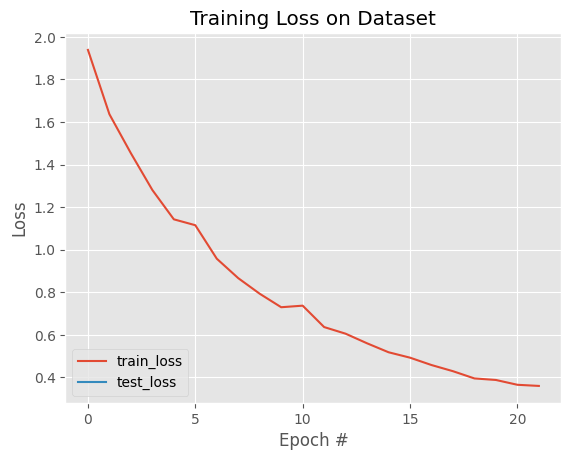

In [16]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

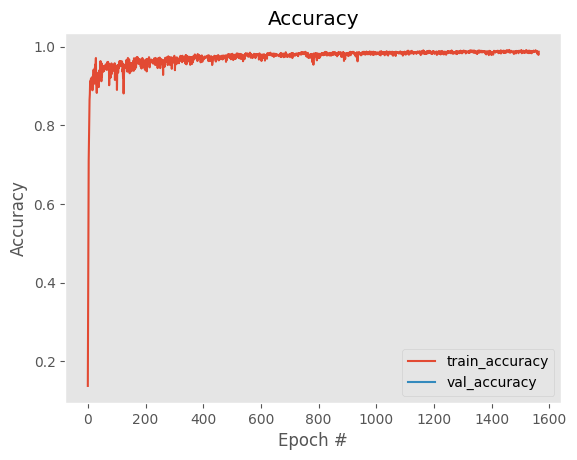

In [17]:
# Accuracy
plt.style.use("ggplot")
plt.figure()

train_accuracy = [x.cpu().numpy() for x in accuracy_dict["train"]]
val_accuracy = [x.cpu().numpy() for x in accuracy_dict["val"]]

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(val_accuracy, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()
plt.show()

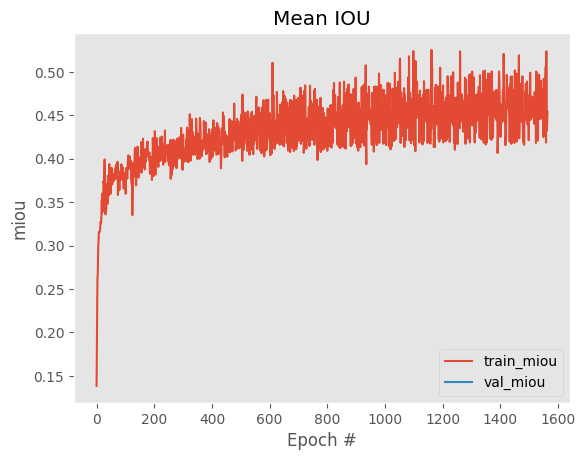

In [18]:
# Mean IoU
train_miou = [x.cpu().numpy() for x in miou_dict["train"]]
val_miou = [x.cpu().numpy() for x in miou_dict["val"]]

plt.plot(train_miou, label="train_miou")
plt.plot(val_miou, label="val_miou")
plt.title("Mean IOU")
plt.xlabel("Epoch #")
plt.ylabel("miou")
plt.legend(loc="lower right")
plt.grid()
plt.show()

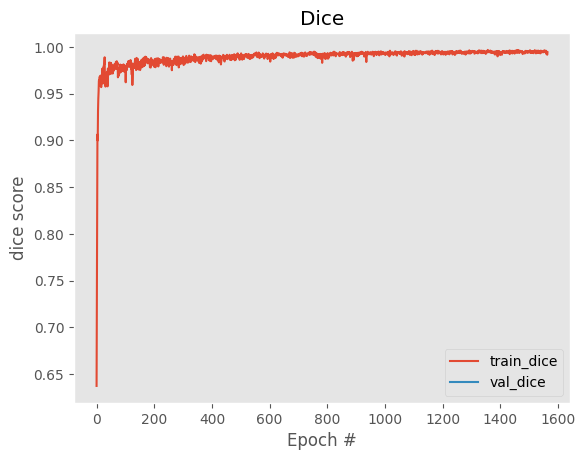

In [19]:
# Dice
train_dice = [x.cpu().numpy() for x in dice_dict["train"]]
val_dice = [x.cpu().numpy() for x in dice_dict["val"]]

plt.plot(train_dice, label="train_dice")
plt.plot(val_dice, label="val_dice")
plt.title("Dice")
plt.xlabel("Epoch #")
plt.ylabel("dice score")
plt.legend(loc="lower right")
plt.grid()
plt.show()

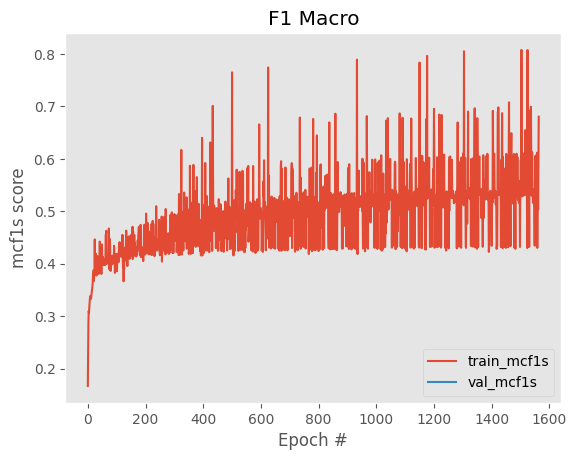

In [21]:
# F1 Macro
train_mcf1s = [x.cpu().numpy() for x in mcf1s_dict["train"]]
val_mcf1s = [x.cpu().numpy() for x in mcf1s_dict["val"]]

plt.plot(train_mcf1s, label="train_mcf1s")
plt.plot(val_mcf1s, label="val_mcf1s")
plt.title("F1 Macro")
plt.xlabel("Epoch #")
plt.ylabel("mcf1s score")
plt.legend(loc="lower right")
plt.grid()
plt.show()